In [1]:
%pylab inline
import random

import numpy as np
import random
import pickle
from tqdm import tqdm
import letor_metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
raw_data = np.loadtxt('/data/charlotte/dat.nf', delimiter=',')

In [3]:
from dataset import TripletsDataset
ds = TripletsDataset(raw_data, threshold_user=60, rnd_seed=42)
ds.train_test_split(n_train=50)

Split users:  12%|█▏        | 482/3938 [00:00<00:01, 2469.99it/s]

In [22]:
ds.train_test_split(n_train=50, seed=135)

In [23]:
pickle.dump(ds, open('./tmp/ds_50_mf.pkl', 'wb'))
# ds = pickle.load(open('./tmp/ds_50_mf.pkl', 'rb'))

In [24]:
ds.init_cached_random()

# define model

In [25]:
import tensorflow as tf
from bprmf import BPR_MF

In [33]:
model.destroy()

In [34]:
N_USERS = 6041 #int(max(raw_data[:, 0])) + 1
N_ITEMS = 3953 #int(max(raw_data[:, 1])) + 1
N_EMBEDDINGS = 3

In [35]:
model = BPR_MF(N_USERS, N_ITEMS, N_EMBEDDINGS, alpha_reg=0.1)
model.build_graph()
model.initialize_session()

In [36]:
losses = []
batch_size = 1024
for n_batches, cur_optim in [(5000, model.trainer_2)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            model.user_ids:  batch['users'], 
            model.left_ids:  batch['left_items'],
            model.right_ids: batch['right_items'],
            model.target_y:  batch['y'],
        }
        el, reg, t, _ = model.session.run(
            [model.embedding_loss, model.regularization, model.target, cur_optim], 
            feed_dict=fd
        )
        losses.append((el, reg, t))
        if i%500==0:
            user_norm = np.linalg.norm(model.weights_u)
            item_norm = np.linalg.norm(model.weights_i)
            print('[it {}] weight norms, users: {}, items: {}'.format(i, user_norm, item_norm))

  0%|          | 16/5000 [00:00<01:25, 58.04it/s]

[it 0] weight norms, users: 63.000648498535156, items: 77.14344787597656


 10%|█         | 525/5000 [00:04<00:36, 121.69it/s]

[it 500] weight norms, users: 36.126243591308594, items: 58.074806213378906


 20%|██        | 1018/5000 [00:08<00:32, 122.63it/s]

[it 1000] weight norms, users: 36.518333435058594, items: 59.3266716003418


 30%|███       | 1523/5000 [00:12<00:28, 122.53it/s]

[it 1500] weight norms, users: 36.62940979003906, items: 59.28971481323242


 40%|████      | 2015/5000 [00:16<00:24, 121.36it/s]

[it 2000] weight norms, users: 36.57758331298828, items: 59.225685119628906


 50%|█████     | 2515/5000 [00:21<00:25, 96.12it/s]

[it 2500] weight norms, users: 36.63778305053711, items: 59.25521469116211


 60%|██████    | 3024/5000 [00:26<00:16, 121.28it/s]

[it 3000] weight norms, users: 36.75723648071289, items: 59.31056213378906


 70%|███████   | 3517/5000 [00:30<00:12, 117.02it/s]

[it 3500] weight norms, users: 36.76970291137695, items: 59.40386199951172


 80%|████████  | 4023/5000 [00:35<00:08, 117.98it/s]

[it 4000] weight norms, users: 36.73135757446289, items: 59.214141845703125


 90%|█████████ | 4520/5000 [00:39<00:04, 119.94it/s]

[it 4500] weight norms, users: 36.97752380371094, items: 59.42841339111328


100%|██████████| 5000/5000 [00:43<00:00, 113.95it/s]


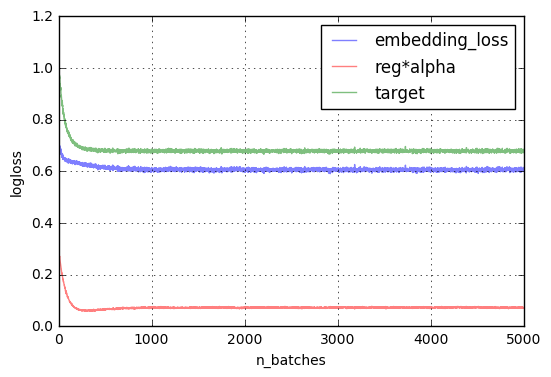

In [37]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1]*model.alpha_reg for x in losses], c='r', label='reg*alpha', alpha=0.5)
plot([x[2] for x in losses], c='g', label='target', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [38]:
ndcg_vals = []
for u in tqdm(ds.data_keys, desc='Prediction', leave=True):
    fd = {
            model.user_ids:  (np.ones(N_ITEMS)*u).astype(np.int32), 
            model.left_ids:  np.array([i for (i, r) in ds.test[u]]).astype(np.int32),
        }
    response = model.session.run(model.embedding_left, feed_dict=fd)[:, 0]

    # make relevances
    relevances = np.array([r for (i, r) in ds.test[u]])
    predicted_ranking = np.argsort(-response)
    # calc score
    gain = letor_metrics.ndcg_from_ranking(relevances, predicted_ranking, 10)
    ndcg_vals.append(gain)

Prediction: 100%|██████████| 3938/3938 [00:02<00:00, 1846.52it/s]


In [39]:
np.mean(ndcg_vals)

0.72090308294543237